In [12]:
import librosa
import pyaudio
import queue
from typing import Optional
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime
from collections import deque

SAMPLE_RATE = 22050
HOP_LENGTH = 256
CHANNELS = 1
N_FFT = 512
feature_rate = int(SAMPLE_RATE / HOP_LENGTH)

In [13]:
class StreamProcessor:
    def __init__(self, sample_rate=SAMPLE_RATE, chunk_size=1024, verbose=True):
        self.chunk_size = chunk_size
        self.channels = CHANNELS
        self.sample_rate = sample_rate
        self.verbose = verbose
        self.format = pyaudio.paFloat32
        self.audio_interface: Optional[pyaudio.PyAudio] = None
        self.audio_stream: Optional[pyaudio.Stream] = None
        self.buffer = queue.Queue()
        self.chroma_buffer = queue.Queue()
        self.last_chunk = None
        self.is_mic_open = False
        self.index = 0

    def _process_frame(self, data, frame_count, time_info, status_flag):
        if self.verbose:
            print(f'\nprocess_frame index: {self.index}, frame_count: {frame_count}')
            print(f"{self.index}st time_info: {time_info}")

        self.buffer.put(data)

        query_audio = np.frombuffer(data, dtype=np.float32)
        query_chroma_stft = librosa.feature.chroma_stft(
            y=query_audio, hop_length=HOP_LENGTH, n_fft=N_FFT
        )
        if self.last_chunk is None:  # first audio chunk is given
            current_chunk = {
                "timestamp": time_info["input_buffer_adc_time"],
                "chroma_stft": query_chroma_stft[:, :-1],
            }
            self.chroma_buffer.put(current_chunk)
            # self.chroma_buffer.put(query_chroma_stft[:, :-1])  # pop last frame converted with zero padding
        else:
            override_previous_padding = librosa.feature.chroma_stft(
                y=np.concatenate((self.last_chunk, query_audio[:HOP_LENGTH])),
                sr=self.sample_rate,
                hop_length=HOP_LENGTH,
                n_fft=N_FFT,
            )[:, 1:-1]  # drop first and last frame converted with zero padding
            accumulated_chroma = np.concatenate((override_previous_padding, query_chroma_stft[:, 1:-1]), axis=1)
            current_chunk = {
                "timestamp": time_info["input_buffer_adc_time"] + HOP_LENGTH / SAMPLE_RATE,
                "chroma_stft": accumulated_chroma,
            }
            self.chroma_buffer.put(current_chunk)
        print(f"[PUT] for {self.index}st frame")
        print(f"queue inside at {self.index}: {self.chroma_buffer.qsize()}")
        self.last_chunk = query_audio[query_audio.shape[0] - HOP_LENGTH:]
        self.index += 1
        return (data, pyaudio.paContinue)

    def run(self):
        self.audio_interface = pyaudio.PyAudio()
        self.audio_stream = self.audio_interface.open(
            format=self.format,
            channels=self.channels,
            rate=self.sample_rate,
            input=True,
            frames_per_buffer=self.chunk_size,
            stream_callback=self._process_frame,
        )
        self.is_mic_open = True
        self.audio_stream.start_stream()
        self.start_time = self.audio_stream.get_time()
        print("* Recording in progress....")

    def stop(self):
        if self.is_mic_open:
            self.audio_stream.stop_stream()
            self.audio_stream.close()
            self.is_mic_open = False
            self.audio_interface.terminate()
            print("Recording Stopped.")

In [14]:
MAX_LEN = int(1e4)
HOP_LENGTH = 256

from enum import IntEnum
import scipy


class Direction(IntEnum):
    REF = 1
    QUERY = 2
    BOTH = REF | QUERY


class OnlineTimeWarping:
    def __init__(
        self,
        sp: StreamProcessor,
        ref_audio_path,
        window_size,
        max_run_count=30,
        hop_length=HOP_LENGTH,
        verbose=True,
    ):
        self.sp = sp
        self.window_size = window_size
        self.max_run_count = max_run_count
        self.hop_length = hop_length
        self.frame_per_seg = int(sp.chunk_size / hop_length)
        self.verbose = verbose
        self.q_index = 0
        self.ref_pointer = 0
        self.time_length = 0
        self.distance = 0
        self.run_count = 0
        self.previous_direction = None
        self.current_query_stft = None  # (12, n)
        self.query_stft = np.zeros((12, MAX_LEN))  # (12, N) stft of total query
        self.query_audio = np.array([])
        self.index1s = np.array([])
        self.index2s = np.array([])
        self.warping_path = None
        self.cost_matrix = np.zeros((self.window_size * self.frame_per_seg, self.window_size * self.frame_per_seg))
        self.dist_matrix = np.zeros_like(self.cost_matrix)
        self.iteration = 0
        self.cost_matrix_offset = [0, 0] # (ref, query)
        self.q_index = 0

        self.initialize_ref_audio(ref_audio_path)
    
    def offset(self):
        window_frame_length = self.frame_per_seg * self.window_size
        return np.array([self.ref_pointer - window_frame_length, self.q_index - window_frame_length])

    def initialize_ref_audio(self, audio_path):
        audio_y, sr = librosa.load(audio_path)
        self.ref_audio = audio_y
        ref_stft = librosa.feature.chroma_stft(y=audio_y, sr=sr, hop_length=HOP_LENGTH, n_fft=N_FFT)
        ref_len = ref_stft.shape[1]
        truncated_len = ((ref_len - 1) // self.frame_per_seg ) * self.frame_per_seg  # initialize_ref_audio 에서 ref_stft 길이가 frame_per_seg (4) 로 나눠지게 마지막을 버림
        self.ref_stft = ref_stft[:, :truncated_len]

        self.global_cost_matrix = np.zeros((self.ref_stft.shape[1] * 2, self.ref_stft.shape[1] * 2))

    def init_dist_matrix(self):
        print('init')
        ref_stft_seg = self.ref_stft[:, :self.ref_pointer] # [F, M]
        query_stft_seg = self.query_stft[:, :self.q_index] # [F, N] 
        dist = scipy.spatial.distance.cdist(ref_stft_seg.T, query_stft_seg.T)

        if self.verbose:
            print(f"ref_stft_seg: {ref_stft_seg.shape}, query_stft_seg: {query_stft_seg.shape}, dist: {dist.shape}, dist_matrix shape: {self.dist_matrix.shape}")
        w = self.window_size * self.frame_per_seg
        self.dist_matrix[w  - dist.shape[0]:, w - dist.shape[1]:] = dist
    
    def update_dist_matrix(self, direction: Direction):
        print(f"update_path_cost with direction: {direction.name}")
        x = self.ref_pointer
        y = self.q_index
        w = self.window_size * self.frame_per_seg

        ref_stft_seg = self.ref_stft[:, max(x - w, 0) : x] # [F, M]
        query_stft_seg = self.query_stft[:, max(y - w, 0) : y] # [F, N]
        dist = scipy.spatial.distance.cdist(ref_stft_seg.T, query_stft_seg.T)
        if self.verbose:
            print(f"current pointer: {(x, y)}, ref shape: {ref_stft_seg.shape} query shape: {query_stft_seg.shape}, dist shape: {dist.shape}, dist_matrix shape: {self.dist_matrix.shape}")

        self.dist_matrix[w - dist.shape[0]:, w - dist.shape[1]:] = dist  # dist_matrix 끝 점에 맞춰서 항상 업데이트 되도록 함.
    
    def update_accumulate_matrix(self):
        # local cost matrix
        table = np.zeros((self.dist_matrix.shape[1] + 1, self.dist_matrix.shape[1] + 1))
        
        # Compute left column separately, i.e. j=0.
        table[1:, 0] = np.inf
            
        # Compute top row separately, i.e. i=0.
        table[0, 1:] = np.inf

        for i in range(1, self.dist_matrix.shape[0]):
            for j in range(1, self.dist_matrix.shape[1]):
                d = self.dist_matrix[i][j]
                self.d = d
                self.table = table
                table[i, j] = d + min(table[i - 1, j], table[i, j - 1], table[i - 1, j - 1])

        self.cost_matrix = table

    def update_direction_matrix(self):
        pass

    def update_warping_path(self):
        table = self.cost_matrix
        i = self.cost_matrix.shape[0] - 1
        j = self.cost_matrix.shape[1] - 1
        path = [(i, j)]
        offset = self.offset()
        ref_until = i - self.ref_pointer
        query_until = j - self.q_index
        print(f"cost_matrix: {table.shape} i: {i}, j: {j}, offset: {offset}, ref until: {ref_until}, query until: {query_until}")
        while i > ref_until and j > query_until:
            minval = np.inf
            print(f"inside while; i: {i}, j: {j}")
            if table[i-1, j] < minval:
                minval = table[i-1, j]
                step = (i-1, j)
            if table[i][j-1] < minval:
                minval = table[i, j-1]
                step = (i, j-1)
            if table[i-1][j-1] < minval:
                minval = table[i-1, j-1]
                step = (i-1, j-1)
            path.insert(0, step)
            i, j = step
        path += offset
        self.warping_path = path

    def update_path_cost(self, direction: Direction = Direction.BOTH):
        self.update_dist_matrix(direction)
        # self.update_accumulate_matrix()
        # self.update_direction_matrix()
        # self.update_warping_path()

    def select_next_direction(self):
        '''
        if self.run_count > self.max_run_count:
            if self.previous_direction == Direction.REF:
                next_direction = Direction.QUERY
            else:
                next_direction = Direction.REF

        last_ref_path, last_query_path = self.warping_path[0]
        if (
            last_ref_path + 1 == self.ref_pointer
            and last_query_path + 1 == self.query_pointer
        ):
            next_direction = Direction.BOTH
        elif last_ref_path < last_query_path:
            next_direction = Direction.QUERY
        elif last_ref_path == last_query_path:
            next_direction = Direction.BOTH
        else:
            next_direction = Direction.REF

        return next_direction
        '''
        return Direction.BOTH

    def get_new_input(self):
        qsize = self.sp.chroma_buffer.qsize()
        if qsize <= 1:
            query_chroma_stft = self.sp.chroma_buffer.get()['chroma_stft']
        else:
            print(f"qsize more than 1!")
            # query_chroma_stft = np.zeros(())
            chroma_stfts = [self.sp.chroma_buffer.get()['chroma_stft'] for _ in range(qsize)]  # (12, self.frame_per_seg) * qsize
            query_chroma_stft = np.hstack(chroma_stfts)
        self.current_query_stft = query_chroma_stft
        q_length = self.current_query_stft.shape[1]
        self.query_stft[:, self.q_index:self.q_index + q_length] = query_chroma_stft
        self.q_index += q_length
        print(f"updated q_index: {self.q_index}, q_length: {q_length}")

    def run(self):
        self.sp.run()  # mic ON
        start_time = time.time()

        self.ref_pointer += self.window_size * self.frame_per_seg
        self.get_new_input()
        self.update_path_cost()

        # while self.sp.is_mic_open:
        while (time.time() - start_time < 12) and (self.ref_pointer <= (self.ref_stft.shape[1] - self.frame_per_seg)):
            if self.verbose:
                print(f"\niteration: {self.iteration}")
            direction = self.select_next_direction()
            if direction is Direction.QUERY:
                self.get_new_input()
                self.update_path_cost(direction)

            elif direction is Direction.REF:
                self.ref_pointer += self.frame_per_seg
                self.update_path_cost(direction)

            elif direction is Direction.BOTH:
                self.get_new_input()
                self.ref_pointer += self.frame_per_seg
                self.update_path_cost(direction)

            # if self.select_next_direction() == self.previous_direction:
            #     self.run_count += 1
            # else:
            #     self.run_count = 1

            # if direction is not Direction.BOTH:
            #     self.previous_direction = direction
            self.iteration += 1

        end_time = time.time()
        print(f"duration: {end_time - start_time}")
        self.sp.stop()

In [15]:
ref_audio_path = "../resources/audio/target/Haydn_Hob.XVI34_1-1.wav"
SAMPLE_RATE = 22050
CHUNK_SIZE = 1024
N_FFT = 512
import traceback

sp = StreamProcessor(SAMPLE_RATE, CHUNK_SIZE)
odtw = OnlineTimeWarping(sp, ref_audio_path, window_size=10)
try:
    odtw.run()
except Exception as e:
    print(f"error! : {str(e)}, {type(e)}")
    traceback.print_tb(e.__traceback__)
    sp.stop()
    pass

* Recording in progress....

process_frame index: 0, frame_count: 1024
0st time_info: {'input_buffer_adc_time': 1515051.346486788, 'current_time': 1515051.394260416, 'output_buffer_dac_time': 0.0}
[PUT] for 0st frame
queue inside at 0: 1
updated q_index: 4, q_length: 4
update_path_cost with direction: BOTH
current pointer: (40, 4), ref shape: (12, 40) query shape: (12, 4), dist shape: (40, 4), dist_matrix shape: (40, 40)

iteration: 0

process_frame index: 1, frame_count: 1024
1st time_info: {'input_buffer_adc_time': 1515051.392944838, 'current_time': 1515051.442245041, 'output_buffer_dac_time': 0.0}
[PUT] for 1st frameupdated q_index: 8, q_length: 4
queue inside at 1: 0

update_path_cost with direction: BOTH
current pointer: (44, 8), ref shape: (12, 40) query shape: (12, 8), dist shape: (40, 8), dist_matrix shape: (40, 40)

iteration: 1

process_frame index: 2, frame_count: 1024
2st time_info: {'input_buffer_adc_time': 1515051.4393575361, 'current_time': 1515051.4902585412, 'output_bu

In [126]:
odtw.cost_matrix.shape

(41, 41)

In [127]:
odtw.ref_pointer, odtw.q_index

(48, 12)

In [128]:
import pandas as pd

df = pd.DataFrame(odtw.cost_matrix)
df

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.0,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.484411,7.813073,9.435742,11.224487,12.750161,13.665924,14.561790,15.780702,16.571777,0.0
2,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.232537,7.555496,9.102868,10.827259,12.289751,13.140831,14.017854,15.230162,16.048004,0.0
3,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.257528,7.602931,9.106546,10.801473,12.250740,13.078184,14.030970,15.319021,16.069455,0.0
4,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.342104,7.653152,9.173437,10.799870,12.251431,13.103052,14.081080,15.396787,16.149251,0.0
5,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.449800,7.750431,9.260852,10.895504,12.282265,13.133188,14.129723,15.474198,16.229927,0.0
6,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.428623,7.783943,9.293457,10.894321,12.295942,13.198094,14.171292,15.562437,16.285833,0.0
7,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.453213,7.775584,9.396170,11.066635,12.411486,13.211839,14.126648,15.389033,16.213944,0.0
8,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.436467,7.625130,9.387845,11.381487,12.759642,13.680469,13.907506,14.865791,15.696223,0.0
9,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.764587,7.729689,9.785520,11.839225,13.505140,14.637804,14.561393,14.767533,15.961958,0.0


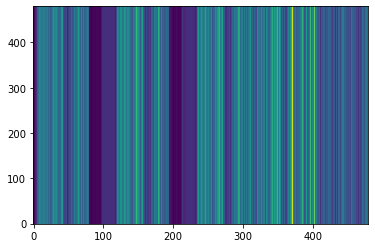

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(odtw.dist_matrix.T, aspect='auto', origin='lower')

In [130]:
df = pd.DataFrame(odtw.warping_path)
df

,0,1
0,9,0
1,9,1
2,9,2
3,9,3
4,9,4
5,9,5
6,9,6
7,9,7
8,9,8
9,9,9


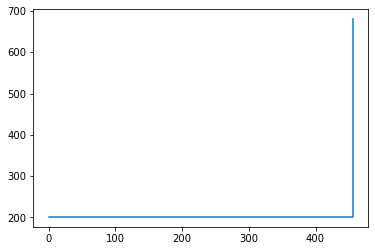

In [175]:
plt.plot(np.flip(odtw.warping_path)[:, 0], np.flip(odtw.warping_path)[:, 1])
plt.show()

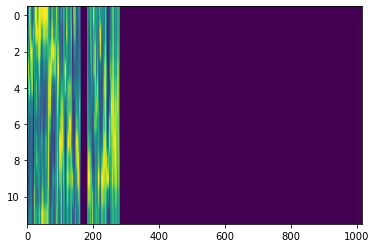

In [17]:
plt.imshow(odtw.query_stft[:, :odtw.q_index], aspect='auto')

In [8]:
data = sp.buffer.get()